In [1]:
import csv
import torch
import numpy as np
import pandas as pd
from time import time
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

In [2]:
# read in raw csv data
train_data_raw = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# split to train and dev set
train_data, dev_data = train_test_split(train_data_raw, test_size=0.025)

# split out labels
train_y = train_data['label']
train_x = train_data.drop('label', axis=1)

dev_y = dev_data['label']
dev_x = dev_data.drop('label', axis=1)

# convert to tensors
train_x_tensor = torch.Tensor(train_x.values)
train_y_tensor = torch.Tensor(train_y.values).type(torch.LongTensor)

dev_x_tensor = torch.Tensor(dev_x.values)
dev_y_tensor = torch.Tensor(dev_y.values).type(torch.LongTensor)

test_tensor = torch.Tensor(test_data.values)

In [3]:
# set up dataloaders
dataloader_train_x = torch.utils.data.DataLoader(train_x_tensor, batch_size=64)
dataloader_train_y = torch.utils.data.DataLoader(train_y_tensor, batch_size=64)

dataloader_dev_x = torch.utils.data.DataLoader(dev_x_tensor, batch_size=64)
dataloader_dev_y = torch.utils.data.DataLoader(dev_y_tensor, batch_size=64)

dataloader_test = torch.utils.data.DataLoader(test_tensor, batch_size=64)

In [16]:
# logistic regression model
input_size = 784 # 784 pixels
hidden_sizes = [256, 128, 64] # number of hidden units in each layer
output_size = 10 # 10 possible digits

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),                                        
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): LogSoftmax(dim=1)
)


In [17]:
# training
error =  nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
epochs = 5

loss_list = []
iteration_list = []
accuracy_list = []

start_time = time()
count = 0

for e in range(epochs):
    for images, labels in zip(dataloader_train_x, dataloader_train_y):
        
        optimizer.zero_grad()
        
        # forward pass       
        output = model(images)
        
        # calculate loss
        loss = error(output, labels)
        
        # backprop
        loss.backward()
        
        # step of stochastic gradient descent
        optimizer.step()

        count += 1
        
        if count % 100 == 0:
            
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            # Iterate through dev dataset
            correct_count, all_count = 0, 0

            for images, labels in zip(dataloader_dev_x, dataloader_dev_y):
                for i in range(len(labels)):
                    with torch.no_grad():
                        img = images[i].view(1,784)
                        output = model(img)
                    ps = torch.exp(output)
                    prob = list(ps.numpy()[0])
                    predicted_label = prob.index(max(prob))
                    true_label = labels.numpy()[i]
                    if predicted_label == true_label:
                        correct_count += 1
                    all_count += 1
            
            accuracy = 100 * correct_count / float(all_count)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            print(f'Iteration: {count}, Accuracy: {accuracy}')
       
training_time = time() - start_time
print(f'Training Time: {training_time} seconds')
        
        

Iteration: 100, Accuracy: 84.19047619047619
Iteration: 200, Accuracy: 88.57142857142857
Iteration: 300, Accuracy: 89.14285714285714
Iteration: 400, Accuracy: 91.71428571428571
Iteration: 500, Accuracy: 91.04761904761905
Iteration: 600, Accuracy: 92.85714285714286
Iteration: 700, Accuracy: 92.19047619047619
Iteration: 800, Accuracy: 93.61904761904762
Iteration: 900, Accuracy: 93.14285714285714
Iteration: 1000, Accuracy: 94.0952380952381
Iteration: 1100, Accuracy: 94.0
Iteration: 1200, Accuracy: 94.76190476190476
Iteration: 1300, Accuracy: 94.38095238095238
Iteration: 1400, Accuracy: 94.47619047619048
Iteration: 1500, Accuracy: 95.33333333333333
Iteration: 1600, Accuracy: 94.19047619047619
Iteration: 1700, Accuracy: 94.57142857142857
Iteration: 1800, Accuracy: 95.23809523809524
Iteration: 1900, Accuracy: 95.04761904761905
Iteration: 2000, Accuracy: 95.23809523809524
Iteration: 2100, Accuracy: 95.42857142857143
Iteration: 2200, Accuracy: 94.57142857142857
Iteration: 2300, Accuracy: 95.714

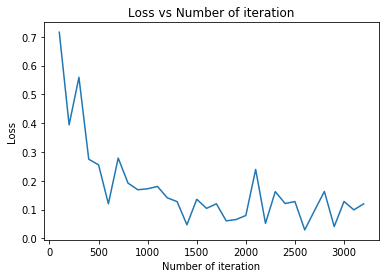

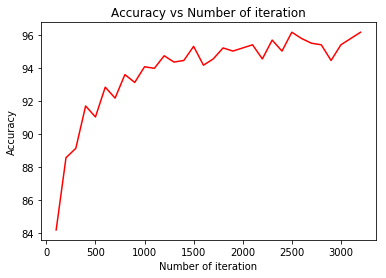

In [18]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.show()

In [19]:
# test on dev set
correct_count, all_count = 0, 0

for images, labels in zip(dataloader_dev_x, dataloader_dev_y):
    for i in range(len(labels)):
        with torch.no_grad():
            img = images[i].view(1,784)
            output = model(img)
        ps = torch.exp(output)
        prob = list(ps.numpy()[0])
        predicted_label = prob.index(max(prob))
        true_label = labels.numpy()[i]
        if predicted_label == true_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 1050

Model Accuracy = 0.9619047619047619


In [22]:
# save model
torch.save(model, './digit-recognizer-model.pt') 

In [13]:
# predictions
predictions = []

for images in dataloader_test:
    for i in range(len(images)):
        with torch.no_grad():
            img = images[i].view(1, 784)
            output = model(img)
        ps = torch.exp(output)
        prob = list(ps.numpy()[0])
        predicted_label = prob.index(max(prob))
        predictions.append(predicted_label)

# save to csv
with open('submission.csv', 'w') as csv_file:
    csvwriter = csv.writer(csv_file, delimiter=',')
    csvwriter.writerow(['ImageId','Label'])
    for i, label in enumerate(predictions):
        image_id = i+1
        csvwriter.writerow([image_id, label])

print('Saved predictions to file: submission.csv')

Saved predictions to file: submission.csv
